In [1]:
#Código completo para la reducción de los datos de ciencia
#creado 25 de Agosto de 2017 (versión 1)
# Paso 1 (generar una lista de archivos separando Bias, SkyFlats y Ciencia)
import numpy as np
import glob
import scipy as sp
import astropy.io.fits as pf
import matplotlib.pyplot as plt
% matplotlib inline

b1=[]          #Creando una lista (Bias)
f1=[]          #Creandço una lista (Flats)
w1=[]          #Creando una lista (Ciencia)

all_files_fits=glob.glob("*.fits") #Leyendo todos archivos *.fits

for files1 in all_files_fits: 
    data10=pf.open(files1)               #Abriendo los archivos listados en all_files
    object=data10[0].header["object"]   #En esta línea buscamos en el header la palabra claves 
    if "Bias" in object:
        b1.append(files1)
    if "Sky" in object:
        f1.append(files1)
    if "wasp" in object:
        w1.append(files1)

texto=open("flats2.txt","w")        #Creando un archivo de texto para guardar los datos Flats

for name in f1:
    texto.write(name+"\n")         
texto.close()

texto=open("Bias2.txt","w")         #Creando un archivo de texto para guardar los datos Bias

for name in b1:
    texto.write(name+"\n")
texto.close()

texto=open("science2.txt","w")      #Creando un archivo de texto para guardar los datos Ciencia

for name in w1:
    texto.write(name+"\n")
texto.close()

KeyError: "Keyword 'OBJECT' not found."

In [6]:
# Paso 2 (Generar el archivo Master Bias)
Bias=np.loadtxt('Bias.txt',dtype=str) #leyendo el archivo .txt donde esta la lista de archivos .fits para Bias
cubo_Bias=[]                                      #Generando un array para guardar los datos de ma media de los Bias 
for k in range(len(Bias)):            #creando los datos para el archivo cubo_Bias
    archivo=pf.open(Bias[k])
    data=archivo[0].data                     #se filtra el archivo con [0] porque los datos estan contenidos allí
    cubo_Bias.append(data)
Master_Bias=sp.median(cubo_Bias,axis=0) #Línea para calcular la media de los Bias conbinados. El filtro [0] interpreta 
                                         #que debe calcular la media de cada archivo por cada pixel en ellos.

In [7]:
def zscale(Bias,  trim = 0.05, contr=1, mask=None):
    """Returns lower and upper limits found by zscale algorithm for improved contrast in astronomical images.

:param mask: bool ndarray
    True are good pixels, pixels marked as False are ignored
:rtype: (min, max)
    Minimum and maximum values recommended by zscale
"""

    if not isinstance(Bias, sp.ndarray):
        Bias = sp.array(Bias)
    if mask is None:
        mask = (sp.isnan(Bias)==False)

    itrim = int(Bias.size*trim)
    x = sp.arange(mask.sum()-2*itrim)+itrim

    sy = sp.sort(Bias[mask].flatten())[itrim:Bias[mask].size-itrim]
    t,b = sp.polyfit(x, sy, 1)

    return b,t*Bias.size/contr+b

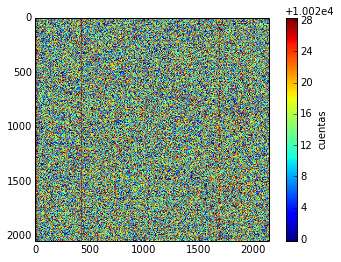

In [9]:
#para graficar el master bias
minv,maxv=zscale(Master_Bias)
plt.imshow(Master_Bias,vmin=minv,vmax=maxv)
plt.colorbar(label='cuentas')
plt.savefig('Master_Bias.png')
plt.show()
pf.writeto("Master_Bias_final.fits", Master_Bias, header=None, output_verify='exception', clobber=False, checksum=False)

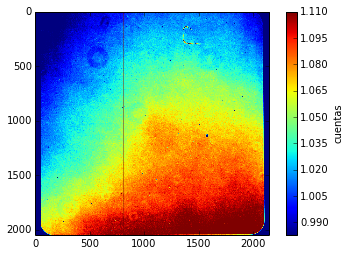

In [11]:
#paso 3 (Generar el archivo Master Flats)
    #se debe restar en cada imagen flats el archivo Master_Bias
flats=np.loadtxt('flats.txt',dtype=str)
#creando una función que calcule el Master_Flats
def master(flats,mb):
    cubo_Flats=[]
    for k in range(len(flats)):
        archivo_flats=pf.open(flats[k])
        data_flats=archivo_flats[0].data
        resta=data_flats-mb
        cubo_Flats.append(resta)
    return cubo_Flats
cubo_Flats=master(flats,Master_Bias)
#normalizar cada flats
cubo_Flats_norm=[]
for imagen in cubo_Flats:
    #Flats_median=np.median(imagen)
    Flats_median=np.average(imagen)
    new_im=imagen/Flats_median
    cubo_Flats_norm.append(new_im)
#saca la mediana combinada luego de normalizar
Master_Flats=sp.median(cubo_Flats_norm,axis=0)
O_Master_Flats=np.array(Master_Flats)

#para graficar el master flats normalizado
minv,maxv=zscale(Master_Flats)
plt.imshow(Master_Flats,vmin=minv,vmax=maxv)
plt.colorbar(label='cuentas')
plt.savefig('Master_Flats_final.png')
plt.show()
#línea para combertir el array en un archivo .fits
pf.writeto("Master_Flats.fits",Master_Flats, header=None, output_verify='exception', clobber=False, checksum=False)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide
/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide


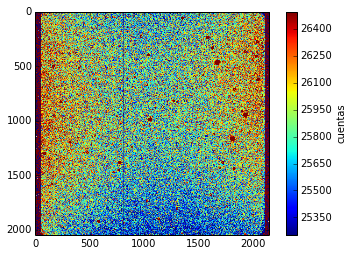

In [13]:
#paso 4 generar los archivos ciencia a detallar 
DATA_science=np.loadtxt('science.txt',dtype=str)#leyendo el archivo .txt donde esta la lista de archivos .fits para Bias
cubo_science=[]                                  #Generando un array para guardar los datos de ma media de los Bias 
for k in range(len(DATA_science)):               #creando los datos para el archivo cubo_Bias
    archivo_science=pf.open(DATA_science[k])
    data_science=archivo_science[0].data        #se filtra el archivo con [0] porque los datos est an contenidos allí
    DATA_FINAL=(data_science-Master_Bias)/Master_Flats
    cubo_science.append(DATA_FINAL)
    
minv,maxv=zscale(cubo_science[1])
plt.imshow(cubo_science[1],vmin=minv,vmax=maxv)
plt.colorbar(label='cuentas')
plt.savefig('Science.png')
plt.show()


In [45]:
#esto es para sacar la estampilla
def stamp(imagen,y,x,radio):
    return imagen[y-radio:y+radio,x-radio:x+radio]

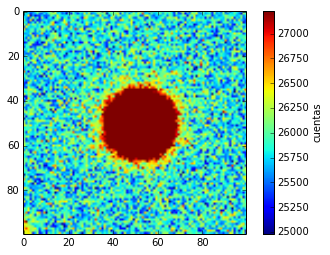

In [50]:
#tener encuenta que python lee primero la coordenada y 'y' luego la 'x' 
science=stamp(cubo_science[1],991,1050,50)
minv,maxv=zscale(science)
plt.imshow(science,vmin=minv,vmax=maxv)
plt.colorbar(label='cuentas')
plt.savefig('stampilla.png')

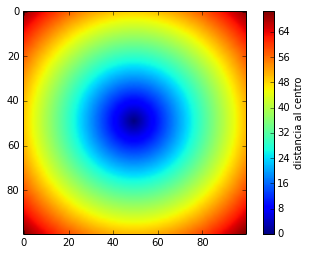

In [90]:
#líneas para calcular el centro de "masas"
from scipy import ndimage
yc,xc=ndimage.measurements.center_of_mass(science) #recordar que la primer coordenada es 'y' y luego es 'x'
AY,AX=np.mgrid[0:len(science),0:len(science)] # genera dos arreglos (0,1,2,3,...,n) del tamaño de la estampilla

#calculando la distancia a todos los puntos respecto del centro de la estampilla
distancia_total=np.sqrt((AX-int(xc))**2+(AY-int(yc))**2)

plt.plot
plt.imshow(distancia_total)
plt.colorbar(label='distancia al centro')
plt.savefig('distancia_centro.png')

<function matplotlib.pyplot.show>

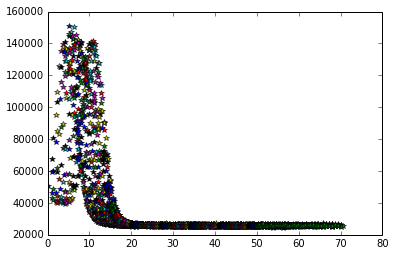

In [91]:
#dibujando el perfil radial 
plt.plot(distancia_total,science,"*")
plt.savefig('perfil_radial.png')
plt.show

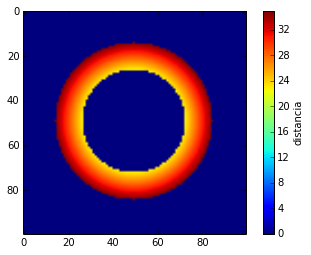

In [92]:
#calculando el promedio de las cuentas para cielo, es decir, debemos extraer del perfil radial, una porcion de
# que represente el valor en cuentas del 'cielo' para luego promediarlo y extraerlo del valor de cuentas de la estrella

radio_interior_anillo=distancia_total>=23 #extraigo la primera parte del anillo
radio_interior_anillo.astype(np.int)                     #combirtiendo de boolean a int
radio_exterior_anillo=distancia_total<=35
radio_exterior_anillo.astype(np.int)                     #combirtiendo de boolean a int
cielo=distancia_total*radio_interior_anillo*radio_exterior_anillo #cielo 

#grafica de cielo en 2D 
plt.plot
plt.imshow(cielo)
plt.colorbar(label='distancia')
plt.savefig('mascara_anillo.png')


<function matplotlib.pyplot.show>

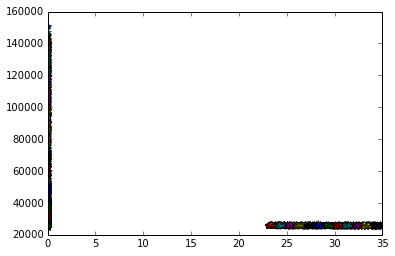

In [93]:
#perfil radial del campo
plt.plot(cielo,science,"*")
plt.show
#consultar a Germán por qué se ven valores en la coordenada (0, :)?

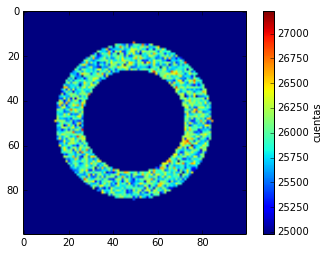

In [94]:
#grafica del campo aplicando mascara anillo
campo_anillo=science*radio_interior_anillo*radio_exterior_anillo 
minv,maxv=zscale(science)
plt.imshow(campo_anillo,vmin=minv,vmax=maxv)
plt.colorbar(label='cuentas')
plt.savefig('campo_anillo.png')

In [95]:
mediana_cielo=np.median(campo_anillo[radio_exterior_anillo])

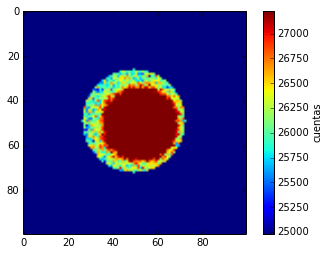

In [131]:
#generando la apertura de la estrella
apertura=distancia_total<=23
apertura.astype(np.int)                     #combirtiendo de boolean a int
apertura_estrella=science*apertura-mediana_cielo
apertura_estrella.astype(np.int)
apertura_estrella1=science*apertura
apertura_estrella1.astype(np.int)
apertura_distancia=distancia_total<=23
apertura_distancia.astype(np.int)                     #combirtiendo de boolean a int
apertura_distancia=apertura_distancia*distancia_total
minv,maxv=zscale(science)
plt.imshow(apertura_estrella1,vmin=minv,vmax=maxv)
plt.colorbar(label='cuentas')
plt.savefig('apertura_extrella.png')

<function matplotlib.pyplot.show>

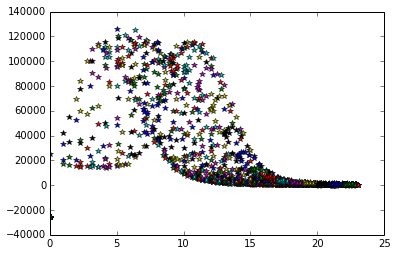

In [132]:
plt.plot(apertura_distancia,apertura_estrella,"*")
plt.show

In [133]:
#apertura valores menores a cero
apertura_estrella[apertura_estrella <0]=0
#a[a < 2] = 0

<function matplotlib.pyplot.show>

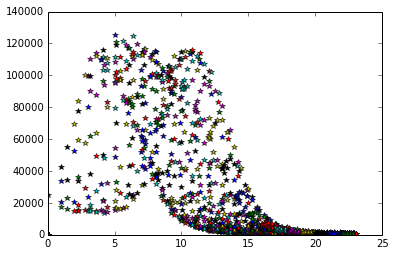

In [134]:
plt.plot(apertura_distancia,apertura_estrella,"*")
plt.show

In [135]:
apertura_estrella.sum(axis=0)   # suma columna (primera dimensión)
flujo=np.array(apertura_estrella.sum(axis=0)) #lo combierto en una lista
flujo_total=np.sum(flujo)    #sumo la lista para tener el flujo total de la estrella en cuentas
flujo_total

32479554.239638709